# The Anatomy of a Model 
## An Introduction to JuMP for Algebraic Modeling

_**[Power Systems Optimization](https://github.com/east-winds/power-systems-optimization)**_

_by Jesse D. Jenkins and Michael R. Davidson (last updated: August 31, 2021)_

This notebook will provide a basic introduction to [algebraic modeling](https://en.wikipedia.org/wiki/Algebraic_modeling_language) for [constrained optimization](https://en.wikipedia.org/wiki/Constrained_optimization) problems using the [Julia](https://julialang.org/) language and [JuMP](http://jump.dev/). The notebook will walk through the main components of an optimization model (decision variables, constraints, expressions, sets, objective function), show how to interface with a solver to find solutions to the model, and how to read solutions outputs back into Julia [DataFrames](https://juliadata.github.io/DataFrames.jl/stable/) and/or [write outputs to .csv files](https://juliadata.github.io/CSV.jl/stable/) for post-processing.

For additional resources, see the collection of notebooks provided at [JuMPTutorials.jl](https://github.com/jump-dev/JuMPTutorials.jl).

<img src="img/jump_logo.png" style="width: 450px; height: auto" align="left">

### What is JuMP?

[JuMP](http://jump.dev/) ("Julia for Mathematical Programming") is an open-source modeling language and supporting packages for mathematical optimization/algebraic programming in the [Julia](https://julialang.org/) high performance scientific programming language. 

JuMP makes it easy to formulate and solve linear programming, semidefinite programming, integer programming, convex optimization, constrained nonlinear optimization, and related classes of optimization problems, using easy-to-read code with syntax that closely matches the mathematical formulation of optimization problems. 

These problems can then be solved via a variety of open source or commercial optimization solvers, using Julia packages for interfacing with each solver. Thus, the definition of an algebraic model for a constrained optimization problem in JuMP is independent of the choice of solver. 

In this way, JuMP is similar to [AMPL](https://en.wikipedia.org/wiki/AMPL), [AIIMS](https://en.wikipedia.org/wiki/AIMMS) or [GAMS](https://en.wikipedia.org/wiki/General_Algebraic_Modeling_System) -- all specialized languages built for algebraic modeling. However, JuMP offers the advantage of being embeded within a fully functioning, high-level programming language (Julia). In this way, it is similar to the [Pyomo](http://www.pyomo.org/) package for Python, but offers the higher computational performance of Julia (and less verbose syntax). (For a brief [comparison between Julia and Python](https://devathon.com/blog/julia-vs-python-which-programming-language-is-better/), see here).

### Installing JuMP

JuMP is a package for Julia. From Julia, JuMP is installed by using the built-in package manager. [See this guide to installing and setting up Julia and JuMP](http://bit.ly/JuliaSetupGuide) if you've not yet done so. But very briefly, one installs JuMP with the following code:

In [1]:
# Note, you don't need to run this block if JuMP is already installed
import Pkg
Pkg.add("JuMP")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


### Loading Julia packages

You only need to install JuMP once, but each time you start up Julia, you'll need to load the JuMP package and any other supporting packages you want to make use of. Here we'll load JuMP, [HGHS.jl](https://github.com/jump-dev/HiGHS.jl), the interface for the open source [HiGHS solver](https://highs.dev/) for linear optimization (LP and MILP problems).

In [2]:
# Note, you don't need to run this block if Clp package is already installed
import Pkg
Pkg.add("HiGHS")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [3]:
# Load JuMP and Clp packages for use in this notebook
using JuMP
using HiGHS

## A factory example

<img src="img/factory.png" style="width: 800px; height: auto" align="left">

Let's start by recalling our simple factory optimization example from the [Constrained Optimization notebook](Notebooks/Constrained-Optimization.ipynb), which seeks to maximize total revenue as a function of how many widgets of type A (decision variable $x$) and type B (decision variable $y$) to produce:


\begin{align}
& \max 150 x + 175 y &\text{Objective function (revenue)}\\ 
& \text{s.t.} & \\
& 10 x + 8 y \leq \ 80 &\text{Time constraint}\\
& 7 x + 11 y \leq \ 77 &\text{Materials constraint}\\
& x \leq 8 &\text{Capacity constraint}\\
& x, y \geq 0 &\text{Non-negativity constraints}\\
\end{align}


In [4]:
# import Pkg; Pkg.add("Plots") # Uncomment and run this line if you need to install Plots package
using Plots

# uncomment the below line if you wish to use the plotly backend (currently not working due to a bug)
# plotly() # use plotly backend: https://docs.juliaplots.org/latest/generated/plotly/

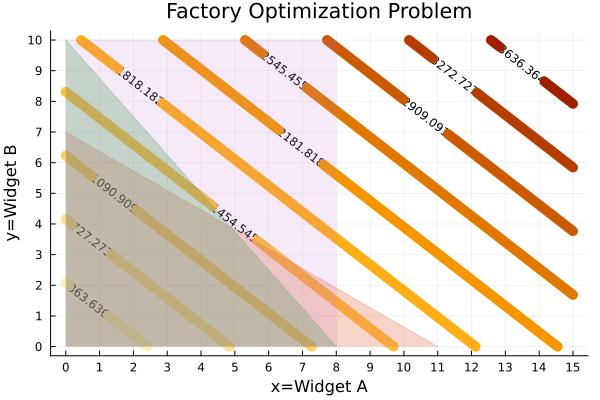

In [5]:
# set up parameters and variables
pa = 150
pb = 175
a = range(0,15,step=0.5)
b = range(0,10,step=0.5)

# define objective function
f(a, b) = begin  (pa*a + pb*b)  end 

contour(a,b,(a,b)->f(a,b),nlevels=10, c=:heat, linewidth=10, colorbar = false, contour_labels = true)
title!("Factory Optimization Problem")
xaxis!("x=Widget A")
yaxis!("y=Widget B")
xticks!(0:maximum(a))
yticks!(0:maximum(b))
areaplot!(a[a.<=11], (77 .- 7*a[a.<=11])./11, legend=false, opacity=0.3)
areaplot!(a[a.<=8], (80 .- 10*a[a.<=8])./8, legend=false, opacity=0.3)
areaplot!(a[a.<=8], repeat([maximum(b)],length(a[a.<=8])), legend=false, opacity=0.15)
#areaplot!([8;0;4.888], [0;7;3.888], legend=false, opacity=1.0)
#scatter!([8 0 4.88],[0 7 3.888])

JuMP allows us to define an algebraic model that represents this optimization problem, which we'll do in several steps now...

### 1. Define the model

First, we **define the model**. A JuMP model object is a container for variables, constraints, solver options, etc. Models are created with the [Model()](https://jump.dev/JuMP.jl/stable/solvers/#JuMP.Model-Tuple{}) function. 

In [6]:
factory_model = Model();

### 2. Specify the optimization solver

To solve a model, we need to also specify the [optimization solver](https://jump.dev/JuMP.jl/stable/solvers/#) (or "optimizer") for JuMP to use. 

A solver is a software package that incorporates computationally efficient algorithms for finding solutions to one or more classes of optimization problems -- e.g. [simplex](https://en.wikipedia.org/wiki/Simplex_algorithm) and [interior-point](https://en.wikipedia.org/wiki/Interior-point_method) algorithms for solving linear programming (LP) problems; [branch-and-bound](https://en.wikipedia.org/wiki/Branch_and_bound) and [branch-and-cut](https://en.wikipedia.org/wiki/Branch_and_cut) algorithms for solving mixed-integer linear programming (MILP) problems.

JuMP currently supports a number of open-source and commercial solvers which can be viewed
[here](https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers).

We specify the specific solver to use for this model either by using the [set_optimizer()](https://jump.dev/JuMP.jl/stable/solvers/#JuMP.set_optimizer) function or as an argument for the [Model()](https://jump.dev/JuMP.jl/stable/solvers/#JuMP.Model-Tuple{}) function when initially defining the model, as in the following examples...

In [7]:
set_optimizer(factory_model, HiGHS.Optimizer)
factory_model = Model(HiGHS.Optimizer);

Above, we specify the HiGHS solver interface. The argument `HiGHS.Optimizer` is an example of a JuMP "Optimizer Factory" parameter, a call to create an interface with a specific solver. Other examples include `GLPK.Optimizer`, `Clp.Optimizer`, `CPLEX.Optimizer`, `Gurobi.Optimizer`, etc.

### 3. Define variables

Next, we define our [decision variables](https://jump.dev/JuMP.jl/stable/variables/), using the JuMP [@variable](https://jump.dev/JuMP.jl/stable/variables/#JuMP.@variable) [macro](https://docs.julialang.org/en/v1/manual/metaprogramming/#man-macros). 

The first argument in the `@variable()` macro is a reference to the model object that this decision variable is associated with, in this case `factory_model`. 

We can also pass lower and/or upper bounds on the decision variables at the time they are created using `<=` and `>=` notation...

In [8]:
@variable(factory_model, 8 >= x >= 0) # How many widgets of type A, including capacity constraint as upper bound

x

In [9]:
@variable(factory_model, y >= 0) # How many widgets of type B

y

...Here we set a lower bound of 0 for both variables (e.g. ```y >= 0```), to reflect the non-negativity constraints in our decision variables (e.g. that we cannot produce a negative amount of widgets), and an upper bound of 8 for variable $x$, to reflect the capacity constraint on production of widget A (```8 >= x >=0```).

You can also specify bounds by using the `lower_bound` and `upper_bound` keyword arguments (as in `@variable(model, x, lower_bound = 0, upper_bound = 8`). 

A variable without bounds is considered a "free variable" and is defined by simply ommitting any bounds (as in `@variable(model, free_x)`).

The name provided for the variable in the `@variable` macro is the "[base name](https://jump.dev/JuMP.jl/stable/variables/#Variable-names-1)" assigned to this variable (e.g. `x` and `y` for our variables above). 

You can use the variable's base name as an argument in other JuMP functions to query attributes of this variable (or to recover a variable's value after solving the model). For example, we can check the upper bound on the `x` variable as follows...

In [10]:
upper_bound(x)

8.0

Note that JuMP requires unique names for variables, expressions, and constraints. If you try to define the same variable name more than once, JuMP will throw an error to prevent you from accidentally overwriting the same variable (or constraint or expression). 

In [11]:
@variable(factory_model, x >= 0) # Try defining x for a second time with different bounds

LoadError: An object of name x is already attached to this model. If this
    is intended, consider using the anonymous construction syntax, e.g.,
    `x = @variable(model, [1:N], ...)` where the name of the object does
    not appear inside the macro.

    Alternatively, use `unregister(model, :x)` to first unregister
    the existing name from the model. Note that this will not delete the
    object; it will just remove the reference at `model[:x]`.


You can see that the $x$ variable still has the old upper bound and has not been modified by the above attempt to define it again. 

In [12]:
upper_bound(x)

8.0

If we'd really wanted to modify the bounds for an existing JuMP variable, we would use the the `set_lower_bound` and `set_upper_bound` functions, or the ` delete_lower_bound` and `delete_upper_bound` functions to remove a previously established bound.

You can check if a name has already been assigned to a valid JuMP object (variable, expression, constraint) with the `is_valid(model_reference, JuMP_base_name)` function, and [delete an existing JuMP object](https://jump.dev/JuMP.jl/dev/variables/#Deleting-variables-1) with the `delete(model_reference, JuMP_base_name)` function.

In [13]:
is_valid(factory_model, x)

true

You can also use JuMP's `all_variables(model_reference)` function to enumerate a vector of references to all defined JuMP variables (although be careful doing this for very large models!)

In [14]:
all_variables(factory_model)

2-element Vector{VariableRef}:
 x
 y

### 4. Define constraints

Next, we can define our more complicated constraints, which involve multiple variables.

We have two constraints to define in this simple example, our time constraint, $10 x + 8 y \leq \ 80$ and our material constraint, $7 x + 11 y \leq \ 77$.

We define constraints with the JuMP [@constraint](https://jump.dev/JuMP.jl/stable/constraints/#The-@constraint-macro-1) macro.

In [15]:
@constraint(factory_model, time_constraint, 10x + 8y <= 80) # Time constraint

time_constraint : 10 x + 8 y ≤ 80

In [16]:
@constraint(factory_model, materials_constraint, 7x + 11y <= 77) # Materials constraint

materials_constraint : 7 x + 11 y ≤ 77

We can now call the model object we've been building, and JuMP will helpfully print out the mathematical formulation

In [17]:
print(factory_model)

As you can see, we've now defined all of the constraints in our simple factory model. But we're missing one very important thing...

### 5. Define objective function

Currently, our model only defines a feasible region (e.g. a set of constraints over the domain of our defined decision variables). But we have not specified what our objective function is: what are we trying to maximize or minimize?

To define our objective function, we use the [@objective](https://jump.dev/JuMP.jl/dev/objective/#JuMP.@objective) macro. We have three arguments for this macro: (1) the model object we are defining the objective for, (2) specify whether this is a maximization (`Max`) or minimization (`Min`) problem, and (3) define the objective function itself.

In [18]:
@objective(factory_model, Max, 150x + 175y)

150 x + 175 y

Now we can see the full model is defined...

In [19]:
print(factory_model)

### 6. Alternative ways to define our model

We can define more than one variable at a time using a more compact syntax by using the [@variables](https://jump.dev/JuMP.jl/stable/variables/#variables-1) macro. Here we'll define both x and y variables at the same time...

In [20]:
factory_model = Model(HiGHS.Optimizer);
@variables(factory_model, begin
    8 >= x >= 0
    y >= 0
    end)
print(factory_model)

Note that the @variables macro does not automatically print the variable bounds, so we use the `print(model_name)` function above to print out the newly defined variables and their bounds.

We can also use the [@constraints](https://jump.dev/JuMP.jl/stable/constraints/#The-@constraints-macro-1) macro in a similar manner to define multiple constraints in a more compact syntax, if preferred...

In [21]:
@constraints(factory_model, begin
    time_constraint, 10x + 8y <= 80
    materials_constraint, 7x + 11y <= 77    
    end)
print(factory_model)

Sometimes it is useful to define an algebraic [expression](https://jump.dev/JuMP.jl/stable/expressions/#) that may be inserted into constraints, objective functions, or other expressions (e.g. to build up more complex expressions or to define an expression used repeatedly in multiple constraints). Defining an expression can also be useful if you want to query the value of a particular expression after solving the model. 

The recommended way to create an expression is via the [@expression](https://jump.dev/JuMP.jl/stable/expressions/#JuMP.@expression) macro, which is syntactically similar to the definition of a constraint. The difference is that an expression is not directly part of the optimization problem definition. It only becomes incorporated into the model definition if you subsequently use a defined expression to define part of a constraint or objective function. As an example, let's use an expression here to define our objective function...

In [22]:
@expression(factory_model, objective, 150x + 175y)
@objective(factory_model, Max, objective)
print(factory_model)

### 7. Solve the model

Now that we've defined our factory model, let's solve it to find the optimal values $(x^*, y^*)$ that maximizes our objective function. 

To optimize a defined JuMP model for which a solver has been previously specified, use the [optimize!](https://jump.dev/JuMP.jl/stable/solvers/#JuMP.optimize!) function, supplying the model name as an argument...

In [23]:
optimize!(factory_model)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 2 cols, 4 nonzeros
2 rows, 2 cols, 4 nonzeros
Presolve : Reductions: rows 2(-0); columns 2(-0); elements 4(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.1874652580e+01 Ph1: 2(2.375); Du: 1(21.8747) 0s
          2     1.4138888889e+03 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  1.4138888889e+03
HiGHS run time      :          0.00


We see that the solver (HiGHS) solved our optimization problem and found the optimal objective function value of 1413.888889. 

### 8. Query the optimal solution

But what are the optimal decision variable values $(x^*, y^*)$? Now that the model has been solved to optimality, we can query the values of JuMP variables by using JuMP's [value()](https://jump.dev/JuMP.jl/stable/solutions/#JuMP.value) function

In [24]:
value(x)

4.888888888888888

In [25]:
value(y)

3.888888888888889

Quick note: because JuMP uses [different containers](https://jump.dev/JuMP.jl/dev/containers/) depending on whether we've defined a single variable, a vector or square array of variables, or an array of variables with differing dimension lengths, they [recommend](https://jump.dev/JuMP.jl/dev/solutions/#Obtaining-solutions-1) using the [vectorized syntax or "dot syntax"](https://docs.julialang.org/en/v1/manual/functions/#man-vectorized) for the `value()` function, `value.(ref)`, rather than the `value(ref)` syntax used above. 

The `value.(ref)` syntax will work with any vector or array of variables and also with single variables (which can be treated as a vector of length 1), while the `value(ref)` syntax will only work when called for single variables. In this case, since we have a single variable only, we can use either syntax. We'll see an example of a vector of variables in the next section of this notebook...

In [26]:
value.(x)

4.888888888888888

In [27]:
value.(y)

3.888888888888889

We can now see the optimal solution to our simple factory optimization model is $(x^*, y^*) = (4.8889, 3.8889)$, just as we determined in the [Constrained Optimization notebook](Notebooks/Constrained-Optimization.ipynb) via linear algebra.

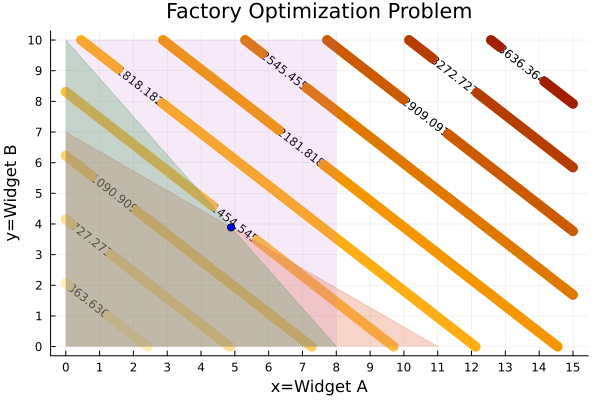

In [28]:
contour(a,b,(a,b)->f(a,b),nlevels=10, c=:heat, linewidth=10, colorbar = false, contour_labels = true)
title!("Factory Optimization Problem")
xaxis!("x=Widget A")
yaxis!("y=Widget B")
xticks!(0:maximum(a))
yticks!(0:maximum(b))
areaplot!(a[a.<=11], (77 .- 7*a[a.<=11])./11, legend=false, opacity=0.3)
areaplot!(a[a.<=8], (80 .- 10*a[a.<=8])./8, legend=false, opacity=0.3)
areaplot!(a[a.<=8], repeat([maximum(b)],length(a[a.<=8])), legend=false, opacity=0.15)
scatter!([value.(x)],[value.(y)], markercolor="blue")

We can also use the `value()` function to evaluate the value of named expressions and constraints we've previously defined and associated with the solved model. (Again, vectorized dot syntax is recommended, but both forms work for single constraints).

In [29]:
value.(time_constraint)

80.0

We can see that this is the same value as we'd get by evaluating the time constraint at the optimal values $(x^*, y^*)$

In [30]:
10*value.(x) + 8*value.(y)

80.0

We can also evaluate the `objective` expression we defined previously, $150x + 175y$, and save this to a variable names `optimal_revenue` (e.g. for use later).

In [31]:
optimal_revenue = value(objective)

1413.8888888888887

Or we can directly query the objective function value associated with our `factory_model` JuMP model object by using JuMP's `objective_value()` function and passing a reference to the model as follows. Since we don't always define an expression for our objective function, this is the typical way to access the objective function value for our optimal solution.

In [32]:
optimal_revenue = objective_value(factory_model)

1413.8888888888887

Note that if there are certain expressions that you want to be able to quickly extract from the model's results, it can make sense to define an expression prior to solving the model, even if you do not use the expression to build a constraint or define the objective function that makes up the actual constrained optimization problem. 

For example, if we wanted to quickly extract the sum of widgets produced $(x+y)$ without individually querying each decision variable value, we could define an expression `@expression(factory_model, total_widgets, x+y)`, and then simply use `value(total_widgets)` to get this sum. 

Obviously, this is a pretty simple expression, but for more complex models, this can be a handy approach to make it easy to extract results of interest.

In [33]:
@expression(factory_model, total_widgets, x+y)

x + y

In [34]:
value.(total_widgets)

8.777777777777777

## A More Complex Model: Optimal Solar + Battery Storage Operations

The factory example above is a pretty simple problem. Useful for introducing the basic anatomy of a JuMP model, but hardly worth relying on algebraic programming to find the solution (as it can be obtained analytically without much trouble). So let's now turn to a more complex example...

<img src="img/solar.png" style="width: 800px; height: auto" align="left">

Assume you are a renewable energy company and you own a 50 megawatt (MW) utility-scale solar PV system and recently installed a 10 MW / 40 megawatt-hour (MWh) Lithium-ion battery system at the same site. Both solar and battery systems take advantage of the same DC-AC inverters (solar PV and batteries are both direct current devices) and transmission grid connection (substation).

Given a series of electricity prices, how should you operate your solar PV and storage system to maximize revenue? When do you charge, and when do you discharge? Should you buy extra power from the grid when it's cheap and store it for later when prices are high, or just make use of your solar PV system to charge the battery? What's the best operational plan to maximize revenue over the next 24 hours?

Sounds like a good optimization problem!

### 1. Load data and define parameters

Before we get started defining our model, we need to load some useful data and define a set of **parameters** or constant values used in our optimization problem.

For purposes of this example, we will use **time series data** for a single day of 15-minute [real-time electricity market prices](http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13061&reportTitle=Historical%20RTM%20Load%20Zone%20and%20Hub%20Prices&showHTMLView=&mimicKey) from the Western Hub of the Electricity Reliability Council of Texas (ERCOT) electricity market, along with simulated solar PV output from [Renewables.Ninja](https://www.renewables.ninja/), which we'll load in from a .csv file with help from Julia's [CSV](https://juliadata.github.io/CSV.jl/stable/) and [DataFrames](https://juliadata.github.io/DataFrames.jl/stable/) packages.

In [35]:
# Note, you don't need to run this block if CSV and DataFrames packages are already installed
import Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [36]:
using CSV
using DataFrames
time_series = DataFrame(CSV.File("anatomy_data/solar_battery_data.csv"))

Row,T,Hour,Interval,Price,Solar
,Int64,Int64,Int64,Float64,Float64
1,1,1,1,12.77,0.0
2,2,1,2,11.82,0.0
3,3,1,3,12.39,0.0
4,4,1,4,10.17,0.0
5,5,2,1,5.86,0.0
6,6,2,2,2.69,0.0
7,7,2,3,1.46,0.0
8,8,2,4,1.41,0.0
9,9,3,1,0.03,0.0


In [37]:
using Plots
# plotly() # use plotly backend: https://docs.juliaplots.org/latest/generated/plotly/

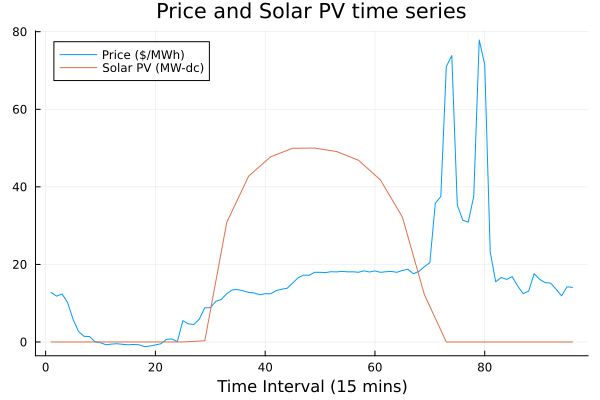

In [38]:
plot(time_series.Price, label="Price (\$/MWh)")
plot!(time_series.Solar, label="Solar PV (MW-dc)")
title!("Price and Solar PV time series")
xaxis!("Time Interval (15 mins)")
yaxis!("")

Additionally, we'll define the following **capacity parameters** for each of the major subcomponents of our solar + battery system...

In [39]:
solar_cap   = 50      # Solar PV capacity in DC MW
battery_cap = 10      # Lithium ion battery power (charge/discharge) capacity in DC MW
energy_cap  = 40      # Lithium ion battery energy capacity (in MWh)
grid_cap    = 40      # DC-AC inverter and grid connection capacity (rated in AC MW)
@show solar_cap
@show battery_cap
@show energy_cap
@show grid_cap

solar_cap = 50
battery_cap = 10
energy_cap = 40
grid_cap = 40


40

Next, we will define a set of **efficiency parameters**, which help govern the flow of electricity through our solar + storage system.

In [40]:
battery_eff = 0.95    # 'Single-trip' charge or discharge efficiency for the Lithium ion battery
inverter_eff = 0.9    # Efficiency of DC-AC or AC-DC conversion at inverter
@show battery_eff
@show inverter_eff

battery_eff = 0.95
inverter_eff = 0.9


0.9

Finally, we set the **starting state of charge** of the battery at the beginning of the simulation day, which we'll assume is half full.

In [41]:
start_charge = 0.5*energy_cap

20.0

### 2. Define the model

Now that we have our parameters set, let's define a new optimization model, a linear programming problem using the Clp open source solver.

In [42]:
PV_model = Model(HiGHS.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS

### 3. Define decision variables

Now we have to define our decision variables. For each of our time intervals, we have five important **operating decisions** to make:

1. How much DC power to produce (or curtail) from our solar PV system
2. How much DC power to charge the battery
3. How much DC power to discharge from the battery
4. How much AC power to export to the grid
5. How much AC power to import from the grid (e.g. to charge the battery)

For the purposes of this optimization problem, we will consider these discrete time decisions taken every 15 minutes. 

Additionally, we will define a final variable:

6. How much energy is stored in the battery (storage state of charge)

While this state of charge variable is technically defined as a decision variable, it is actually completely constrained by the other variables, as we'll see below. This is an example of a [state variable](https://en.wikipedia.org/wiki/State_variable). We'll come back to state variables in dynamical systems when we introduce time coupling constraints in more depth in the Economic Dispatch notebook... 

Since we take the same kinds of decisions in each 15 minute time interval, we will thus define **an array of decision variables** for each type of decision, indexed across all time periods `t` in the set `T` as defined by our time series data `time_series.T`. 

This is our first example of creating an array of variables and **indexing across sets**. In practice, you'll frequently define arrays of variables and constraints that repeat across various sets or dimensions of your data (e.g. time periods, generators, regions, transmission lines). Note that variables can be indexed across multiple dimensions in N-dimensional containers (although here we will only index across the single dimension: time periods). [Read more on variable containers here](https://jump.dev/JuMP.jl/stable/manual/variables/#Variable-containers).

Additionally, we will define bounds for each decision variable based on the capacity parameters set previously. We'll set solar's upper bounds later, as these vary by time interval depending on the availability of solar insolation at the time.

Note: by convention, and to make it easy to spot a decision variable in future expressions, we'll use the convention that all decision variable names will follow the format `UPPERCASE`. (This is an optional convention, and you can feel free to adopt your own, but we recommend adopting a consistent convention for naming variables, constraints, expressions, parameters, etc.)

In [43]:
# Decision variables and bounds:

@variables(PV_model, begin
                          SOLAR[t in time_series.T]      >= 0
        battery_cap    >= CHARGE[t in time_series.T]     >= 0
        battery_cap    >= DISCHARGE[t in time_series.T]  >= 0
        grid_cap       >= GRIDEXPORT[t in time_series.T] >= 0
        grid_cap       >= GRIDIMPORT[t in time_series.T] >= 0
        energy_cap     >= SOC[t in time_series.T]        >= 0
                          
end)
print(PV_model)

### 4. Define expressions

Now we define an  expressions that relate the flow of electricity within our solar + storage system. 

Note that by convention, and to distinguish expression names from decision variable names and constraint names, we will use the convention that all expression names take the format `eExpressionName`. (This is an optional convention, and you can feel free to adopt your own, but we recommend adopting a consistent convention for naming variables, constraints, expressions, parameters, etc.)

1. First, the net solar + storage DC power production or consumption can be expressed by the sum of solar PV and battery discharge less battery charging in each time period `t`. 

$\begin{align*} 
eNetSolarStorage_t = SOLAR_t + DISCHARGE_t - CHARGE_t \quad \forall t \in T
\end{align*}$

We next combine grid exports, $GRIDEXPORT$, and grid imports, $GRIDIMPORT$, to form a "net grid export" expression representing the net interchange of power with the grid in DC terms, after accounting for conversion losses from DC to AC power for exports and AC to DC power for imports.

$\begin{align*} 
eNetExport_t = \frac{GRIDEXPORT_t}{inverter\_eff} - GRIDIMPORT_t \times inverter\_eff \quad \forall t \in T
\end{align*}$


As with our variables, we will define this expression as an array indexed across the set of time periods `t` in the time series `T`, since this holds for all time periods...

In [44]:
# System production and grid export/import flow
@expression(PV_model, eNetSolarStorage[t in time_series.T], 
    SOLAR[t] + DISCHARGE[t] - CHARGE[t])
@expression(PV_model, eNetExport[t in time_series.T], 
    GRIDEXPORT[t]/inverter_eff - GRIDIMPORT[t]*inverter_eff);

You can view the full expressions, constraints, etc., of a JuMP model by using Julia's **@show** command. Note: for larger models, this is not recommended as it may crash your notebook. Here, we just output the first five elements:

In [45]:
@show(eNetSolarStorage[1:5]);
@show(eNetExport[1:5]);

eNetSolarStorage[1:5] = 1-dimensional DenseAxisArray{AffExpr,1,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5]
And data, a 5-element Vector{AffExpr}:
 SOLAR[1] + DISCHARGE[1] - CHARGE[1]
 SOLAR[2] + DISCHARGE[2] - CHARGE[2]
 SOLAR[3] + DISCHARGE[3] - CHARGE[3]
 SOLAR[4] + DISCHARGE[4] - CHARGE[4]
 SOLAR[5] + DISCHARGE[5] - CHARGE[5]
eNetExport[1:5] = 1-dimensional DenseAxisArray{AffExpr,1,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5]
And data, a 5-element Vector{AffExpr}:
 1.1111111111111112 GRIDEXPORT[1] - 0.9 GRIDIMPORT[1]
 1.1111111111111112 GRIDEXPORT[2] - 0.9 GRIDIMPORT[2]
 1.1111111111111112 GRIDEXPORT[3] - 0.9 GRIDIMPORT[3]
 1.1111111111111112 GRIDEXPORT[4] - 0.9 GRIDIMPORT[4]
 1.1111111111111112 GRIDEXPORT[5] - 0.9 GRIDIMPORT[5]


2. Second, the **total revenue** from sale or purchase of electricity in each time period is expressed by the sum product of prices in each interval times the net AC energy exported (or imported) to (or from) the grid (using the $GRIDEXPORT$ and $GRIDIMPORT$ decision variables). Since prices are expressed per whole MWh and our time intervals are 15 minutes (1/4 of an hour), we multiply the net flow of AC power by 0.25 to determine the total energy sold/purchased.

$\begin{align*} 
&eRevenue = \sum_{t \in T} (GRIDEXPORT_t - GRIDIMPORT_t) \times Price_t \times 0.25
\end{align*}$

Here we see our first example of the syntax for a sum expression.

In [46]:
@expression(PV_model, eRevenue, sum((GRIDEXPORT[t]-GRIDIMPORT[t])*time_series.Price[t]*0.25 
        for t in time_series.T));

In [47]:
@show(eRevenue);

eRevenue = 3.1925 GRIDEXPORT[1] - 3.1925 GRIDIMPORT[1] + 2.955 GRIDEXPORT[2] - 2.955 GRIDIMPORT[2] + 3.0975 GRIDEXPORT[3] - 3.0975 GRIDIMPORT[3] + 2.5425 GRIDEXPORT[4] - 2.5425 GRIDIMPORT[4] + 1.465 GRIDEXPORT[5] - 1.465 GRIDIMPORT[5] + 0.6725 GRIDEXPORT[6] - 0.6725 GRIDIMPORT[6] + 0.365 GRIDEXPORT[7] - 0.365 GRIDIMPORT[7] + 0.3525 GRIDEXPORT[8] - 0.3525 GRIDIMPORT[8] + 0.0075 GRIDEXPORT[9] - 0.0075 GRIDIMPORT[9] - 0.0475 GRIDEXPORT[10] + 0.0475 GRIDIMPORT[10] - 0.18 GRIDEXPORT[11] + 0.18 GRIDIMPORT[11] - 0.135 GRIDEXPORT[12] + 0.135 GRIDIMPORT[12] - 0.1125 GRIDEXPORT[13] + 0.1125 GRIDIMPORT[13] - 0.15 GRIDEXPORT[14] + 0.15 GRIDIMPORT[14] - 0.18 GRIDEXPORT[15] + 0.18 GRIDIMPORT[15] - 0.1575 GRIDEXPORT[16] + 0.1575 GRIDIMPORT[16] - 0.18 GRIDEXPORT[17] + 0.18 GRIDIMPORT[17] - 0.2975 GRIDEXPORT[18] + 0.2975 GRIDIMPORT[18] - 0.26 GRIDEXPORT[19] + 0.26 GRIDIMPORT[19] - 0.19 GRIDEXPORT[20] + 0.19 GRIDIMPORT[20] - 0.1175 GRIDEXPORT[21] + 0.1175 GRIDIMPORT[21] + 0.17 GRIDEXPORT[22] - 0.17 GRID

Note that JuMP automatically interprets our expression definitions by converting the parameter references to constants and distributing terms into a [linear combination](https://en.wikipedia.org/wiki/Linear_combination) of coefficients and decision variabes, as per the displayed text above. So feel free to define these expressions however you'd like, and JuMP will take care of the math...

### 5. Constraints

Now we define a set of constraints that define the feasible region for our decision variables, based on the engineering constraints for our solar and storage system.

Note that by convention, and to distinguish constraint names from decision variable names and expression names, we will use the convention that all constraint names take the format `cConstraintName`. (This is an optional convention, and you can feel free to adopt your own, but we recommend adopting a consistent convention for naming variables, constraints, expressions, parameters, etc.)

1. First, we must conserve energy in each time interval. Power produced in the system over each 15 minute interval must match the net power injected into the grid, accounting for losses from converting DC to AC power and vice versa at the inverter ($inverter\_eff$). This is what is known as an **energy balance constraint**. We'll make use of our previously defined expression for net DC power produced/consumed by our solar+storage system ($eNetSolarStorage$) and our expression for net DC exports/imports ($eNetExports$) here, and ensure that the two expressions always always equal -- no free energy here! 

$\begin{align*} 
\quad eNetSolarStorage = eNetExport \quad \forall t \in T
\end{align*}$

In [48]:
@constraint(PV_model, 
    cEnergyBalance[t in time_series.T], # Named array of constraints indexed across all times t in T
    eNetSolarStorage[t] == eNetExport[t]  # Constraint definition
);

In [49]:
@show(cEnergyBalance[1:5]);

cEnergyBalance[1:5] = 1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5]
And data, a 5-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 cEnergyBalance[1] : SOLAR[1] - CHARGE[1] + DISCHARGE[1] - 1.1111111111111112 GRIDEXPORT[1] + 0.9 GRIDIMPORT[1] = 0
 cEnergyBalance[2] : SOLAR[2] - CHARGE[2] + DISCHARGE[2] - 1.1111111111111112 GRIDEXPORT[2] + 0.9 GRIDIMPORT[2] = 0
 cEnergyBalance[3] : SOLAR[3] - CHARGE[3] + DISCHARGE[3] - 1.1111111111111112 GRIDEXPORT[3] + 0.9 GRIDIMPORT[3] = 0
 cEnergyBalance[4] : SOLAR[4] - CHARGE[4] + DISCHARGE[4] - 1.1111111111111112 GRIDEXPORT[4] + 0.9 GRIDIMPORT[4] = 0
 cEnergyBalance[5] : SOLAR[5] - CHARGE[5] + DISCHARGE[5] - 1.1111111111111112 GRIDEXPORT[5] + 0

You can see that JuMP automatically interprets the expressions here to construct constraints that are [linear combinations](https://en.wikipedia.org/wiki/Linear_combination) of parameters and decision variables only, and moves to the right hand side a single constant (in this case $0$.) That is, JuMP automatically converts all constraint expressions to the form:

$\begin{align*}
&a_1 \times x_1 + a_2 \times x_2 + ... + a_N \times x_N == b\\
&\text{or: } \sum_{i=1:N} a_i x_i == b
\end{align*}$  

...or the equivalent with inequalities ($\geq$ or $\leq)$ replacing the equality constraint. 

So feel free to express constraint definitions in whatever way is most intuitive to you, and JuMP will figure out the rest.

2. The **state of charge** of the battery is constrainted to be equal to the state of charge in the prior time period `t-1` plus the energy charged during this time period less the energy discharged during this time period, accounting for storage efficiency losses. 

$\begin{align*} 
SOC_t = SOC_{t-1} + 0.25\big(CHARGE_t * battery\_eff - \frac{DISCHARGE_t}{battery\_eff}\big)  \quad \forall t \in T
\end{align*}$

Note that as we model 15 minute time steps here, we multiply the charge and discharge power (in MW) by 0.25 to determine the change in stored energy (in MWh). 

This is an example of a recursive constraint: the state of charge in each period depends on the state of charge in the prior period. So we have to define a special case for the first time period, with the starting state of charge as the simulation defined by a parameter earlier.

In [50]:
# First period state of charge:
@constraint(PV_model, cStateOfChargeStart,
    SOC[1] == start_charge + (CHARGE[1]*battery_eff - DISCHARGE[1]/battery_eff)*0.25
) 

# All other time periods, defined recursively based on prior state of charge:
@constraint(PV_model, cStateOfCharge[t in time_series.T[(time_series.T .> 1)]],
    SOC[t] == SOC[t-1] + (CHARGE[t]*battery_eff - DISCHARGE[t]/battery_eff)*0.25
);

In [51]:
@show(cStateOfCharge[2:5]) # display constraints

cStateOfCharge[2:5] = 1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, [2, 3, 4, 5]
And data, a 4-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 cStateOfCharge[2] : -0.2375 CHARGE[2] + 0.2631578947368421 DISCHARGE[2] - SOC[1] + SOC[2] = 0
 cStateOfCharge[3] : -0.2375 CHARGE[3] + 0.2631578947368421 DISCHARGE[3] - SOC[2] + SOC[3] = 0
 cStateOfCharge[4] : -0.2375 CHARGE[4] + 0.2631578947368421 DISCHARGE[4] - SOC[3] + SOC[4] = 0
 cStateOfCharge[5] : -0.2375 CHARGE[5] + 0.2631578947368421 DISCHARGE[5] - SOC[4] + SOC[5] = 0


1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, [2, 3, 4, 5]
And data, a 4-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 cStateOfCharge[2] : -0.2375 CHARGE[2] + 0.2631578947368421 DISCHARGE[2] - SOC[1] + SOC[2] = 0
 cStateOfCharge[3] : -0.2375 CHARGE[3] + 0.2631578947368421 DISCHARGE[3] - SOC[2] + SOC[3] = 0
 cStateOfCharge[4] : -0.2375 CHARGE[4] + 0.2631578947368421 DISCHARGE[4] - SOC[3] + SOC[4] = 0
 cStateOfCharge[5] : -0.2375 CHARGE[5] + 0.2631578947368421 DISCHARGE[5] - SOC[4] + SOC[5] = 0

Because of this special definition, we use a generic array of type "Any", but JuMP still recognizes this the same as our constraints above.

3. Finally, we must constrain the **maximum solar PV output** to reflect the weather-dependent variation in solar insolation in each time period. The maximum available solar power output in each time interval is provided by the parameters in the Solar time series input data. Thus, the constraint is of the form:

$\begin{align*} 
SOLAR \leq time\_series.Solar_t \quad \forall t \in T
\end{align*}$

In [52]:
@constraint(PV_model, cMaxSolar[t in time_series.T], 
    SOLAR[t] <= time_series.Solar[t]
);

In [53]:
@show(cMaxSolar[25:45]);

cMaxSolar[25:45] = 1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, [25, 26, 27, 28, 29, 30, 31, 32, 33, 34  …  36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
And data, a 21-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 cMaxSolar[25] : SOLAR[25] ≤ 0
 cMaxSolar[26] : SOLAR[26] ≤ 0.077
 cMaxSolar[27] : SOLAR[27] ≤ 0.154
 cMaxSolar[28] : SOLAR[28] ≤ 0.232
 cMaxSolar[29] : SOLAR[29] ≤ 0.309
 cMaxSolar[30] : SOLAR[30] ≤ 7.94
 cMaxSolar[31] : SOLAR[31] ≤ 15.571
 cMaxSolar[32] : SOLAR[32] ≤ 23.202
 cMaxSolar[33] : SOLAR[33] ≤ 30.833
 cMaxSolar[34] : SOLAR[34] ≤ 33.823
 cMaxSolar[35] : SOLAR[35] ≤ 36.812
 cMaxSolar[36] : SOLAR[36] ≤ 39.801
 cMaxSolar[37] : SOLAR[37] ≤ 42.791
 cMaxSolar[38] : SOLAR[38] ≤ 44.02

### 6. Set Objective Function

Finally, we set our objective function, which is to maximize the revenue from our solar and storage system across the time series (one day). We can make use of the revenue expression we defined previous:

$\begin{align*} 
\max eRevenue &=\\
&\sum_{t \in T} (GRIDEXPORT_t - GRIDIMPORT_t) \times Price_t \times 0.25
\end{align*}$

In [54]:
@objective(PV_model, Max, eRevenue);




Let's take a look at our full model...


In [55]:
print(PV_model)


A little more complicated, eh? Now you can see why it is useful to have an algebraic programming language to define more complex models and then hand over to a solver to do the hard math. 

As JuMP enumerates each individual variable when printing the model, here's a more compact algebraic definition of the solar and storage optimal dispatch problem:


$
{\scriptstyle\begin{align*}
& \max \sum_{t \in T} (GRIDEXPORT_t - GRIDIMPORT_t) \times Price_t \times 0.25 && \text{Objective function (revenue)}\\[6pt] 
& \text{s.t.} && \\[6pt]
& eNetSolarStorage_t = SOLAR_t + DISCHARGE_t - CHARGE_t & \forall t \in T &\quad \text{Net solar and storage production (DC MW)} \\[6pt]
& eNetExport_t = \frac{GRIDEXPORT_t}{inverter\_eff} - GRIDIMPORT_t \times inverter\_eff & \forall t \in T &\quad \text{Net grid interchange (DC MW)} \\[6pt]
& eNetSolarStorage_t = eNetExport_t  & \forall t \in T &\quad \text{Energy balance constraint} \\[6pt]
& SOC_1 = start\_charge + 0.25 \big(CHARGE_1 * battery\_eff - \frac{DISCHARGE_1}{battery\_eff}\big)  & &\\[6pt]
& SOC_t = SOC_{t-1} + 0.25 \big(CHARGE_t * battery\_eff - \frac{DISCHARGE_t}{battery\_eff}\big)  & \forall t \in T \text{ \& } t > 1 &\quad \text{State of charge constraints}\\[6pt]
& SOLAR_t  \leq time\_series.Solar_t     &\forall t \in T & \quad \text{Solar PV capacity constraints}\\[6pt]
& CHARGE_t     \leq battery\_cap         &\forall t \in T & \quad \text{Charge capacity constraints}\\[6pt]
& DISCHARGE_t    \leq battery\_cap      &\forall t \in T & \quad \text{Discharge capacity constraints}\\[6pt]
& SOC_t    \leq energy\_cap             &\forall t \in T & \quad \text{State of charge capacity constraints}\\[6pt]
& GRIDEXPORT_t    \leq grid\_cap      &\forall t \in T & \quad \text{Grid capacity constraint (exports)}\\[6pt]
& GRIDIMPORT_t    \leq grid\_cap             &\forall t \in T & \quad \text{Grid capacity constraint (imports)}\\[6pt]
& SOLAR_t, CHARGE_t, DISCHARGE_t, &&\\
& SOC_t, GRIDEXPORT_t, GRIDIMPORT_t, \geq 0 &\forall t \in T & \quad \text{Non-negativity constraints}\\[6pt]
\end{align*}}
$




Let's optimize this problem!

In [56]:
optimize!(PV_model)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
192 rows, 527 cols, 814 nonzeros
185 rows, 520 cols, 800 nonzeros
Presolve : Reductions: rows 185(-103); columns 520(-56); elements 800(-159)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
        245    -7.2909609789e+03 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 245
Objective value     :  7.2909609789e+03
HiGHS run time      :          0.00


### Results!

We can see from the solver that the optimal revenue is \$7290. 

We can now access the optimal decision variables as well. As these are now arrays of variables, we must use the [vectorized syntax](https://docs.julialang.org/en/v1/manual/functions/#man-vectorized) version of JuMP's `value()` function: `value.(ArrayOfVariablesReference)` 

Similarly, for or arrays of expressions or constraints, use: `value.(ArrayOfExpressionsReference)` or `value.(ArrayOfConstraintsReference)`.

For example, here's the optimal state of charge for the battery across the day:

In [57]:
value.(SOC)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  87, 88, 89, 90, 91, 92, 93, 94, 95, 96]
And data, a 96-element Vector{Float64}:
 17.36842105263158
 14.736842105263158
 12.105263157894736
  9.473684210526315
  6.842105263157894
  4.210526315789473
  2.0
  2.0
  4.375
  6.75
  9.125
 11.5
 13.875
  ⋮
 -0.0
 -0.0
  2.375
  2.375
  0.0
 -0.0
 -0.0
 -0.0
  0.0
 -0.0
 -0.0
  0.0

Additionally, we can compile all of the results into a DataFrame and write to a csv to save our outputs for further analysis.

Note however that `value.(Reference)` will return a JuMP [DenseAxisArray](https://jump.dev/JuMP.jl/dev/variables/#variable_jump_arrays-1) which is not a data format that is compatible with DataFrames. To access the numerical values for an array of JuMP variables or expressions in a DenseAxisArray, you use the syntax `value.(Reference).data`.

In [58]:
typeof(value.(SOC))

JuMP.Containers.DenseAxisArray{Float64, 1, Tuple{Vector{Int64}}, Tuple{JuMP.Containers._AxisLookup{Dict{Int64, Int64}}}}

In [59]:
typeof(value.(SOC).data)

Vector{Float64} (alias for Array{Float64, 1})

Below we compile the DataFrame and write it to .csv file. Note that we copy in the time intervals and price in each time period from the input time series as well for context.

In [60]:
results = DataFrame(
    T = time_series.T,
    Price = time_series.Price,
    Solar_Output = value.(SOLAR).data, 
    Storage_Discharge = value.(DISCHARGE).data,
    Storage_Charge = value.(CHARGE).data,
    Storage_SOC = value.(SOC).data,
    Export = value.(GRIDEXPORT).data,
    Import = value.(GRIDIMPORT).data,
    Interval_Revenue = (value.(GRIDEXPORT).data-value.(GRIDIMPORT).data) .* time_series.Price *0.25
    )

Row,T,Price,Solar_Output,Storage_Discharge,Storage_Charge,Storage_SOC,Export,Import,Interval_Revenue
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,12.77,-0.0,10.0,0.0,17.3684,9.0,0.0,28.7325
2,2,11.82,-0.0,10.0,0.0,14.7368,9.0,0.0,26.595
3,3,12.39,-0.0,10.0,0.0,12.1053,9.0,0.0,27.8775
4,4,10.17,-0.0,10.0,0.0,9.47368,9.0,0.0,22.8825
5,5,5.86,-0.0,10.0,0.0,6.84211,9.0,0.0,13.185
6,6,2.69,-0.0,10.0,0.0,4.21053,9.0,0.0,6.0525
7,7,1.46,-0.0,8.4,0.0,2.0,7.56,0.0,2.7594
8,8,1.41,-0.0,0.0,0.0,2.0,-0.0,0.0,-0.0
9,9,0.03,-0.0,0.0,10.0,4.375,0.0,11.1111,-0.0833333


In [61]:
# Let's create a folder for our results
path = "results" # Replace this with a different path if you prefer to write to another location
if !ispath(path) 
    mkdir(path)
end
write_path = joinpath(path, "solar_storage_results.csv") 
CSV.write(write_path, results)

"results/solar_storage_results.csv"

Finally, let's plot the optimal operational decisions for our solar and storage system....

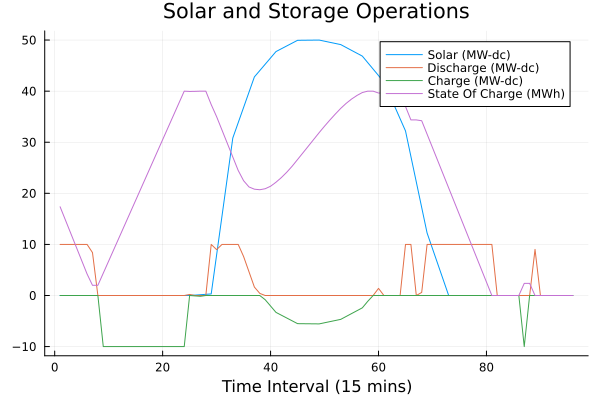

In [62]:
plot(results.Solar_Output, label="Solar (MW-dc)")
plot!(results.Storage_Discharge, label="Discharge (MW-dc)")
plot!(-1*results.Storage_Charge, label="Charge (MW-dc)")
plot!(results.Storage_SOC, label="State Of Charge (MWh)")
title!("Solar and Storage Operations")
xaxis!("Time Interval (15 mins)")
yaxis!("")

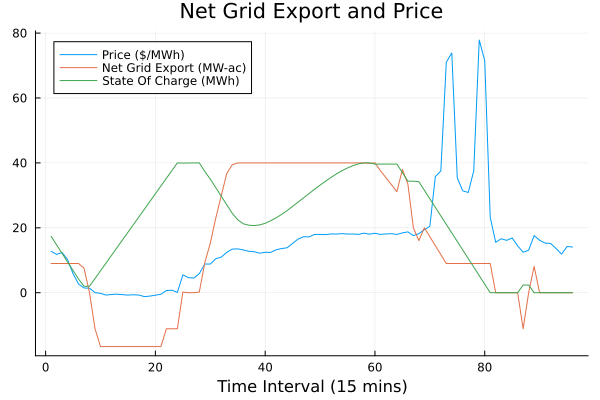

In [63]:
plot(results.Price, label="Price (\$/MWh)")
plot!(results.Export- results.Import, label="Net Grid Export (MW-ac)")
plot!(results.Storage_SOC, label="State Of Charge (MWh)")
title!("Net Grid Export and Price")
xaxis!("Time Interval (15 mins)")
yaxis!("")

You can see that the storage system charges during the morning hours by importing power from the grid when energy prices are zero or slightly negative (which means the storage system gets paid to charge!) and discharges a bit during the morning as solar comes on and prices go positive. Later, the system charges storage from a portion of the solar PV output during the middle of the day to avoid curtailing solar output that peaks at 50 MW-dc and exceeds the grid connection capacity (40 MW-ac or 44.444 MW-dc accounting for inverter losses prior to export). This energy is then discharged and exported during the evening when solar output is gone and electricity prices spike to their highest level of the day.